---
**Chapter 12:**
# **Generative AI**
---

In [1]:
# System Libraries
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import math

# Check GPU
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
# **Basics**
---

**Definition:**
- Learn latent information from the training dataset to generate/synthesize new information
 
**Generation Temperature:**
- **Temperature**: Softmax Entropy: Synthesis randomness
- **Max entropy**: Uniform probability distribution has max randomness (temperature)
- **Low entropy**:  Greedy sampling. Very low randomness in the synthesis
- **High entropy**: Very high randomness in the synthesis

Higher entropy produces interesting but non-realistic results

Lower entropy produces non-interesting but realistic results

---
# **Techniques**
---

**Text generation**:
  - **LSTM**: Long Short Term Memory
  - **GPT**: Generative Pre-Trained Transformer

**Deep Dream**:
  - Conserve the content of image while adapting the style of reference image
  - Visualize output of the filters using Gradient Ascent process
  - Trained on ImageNet where dogs and birds are predominant

**Neural Style Transfer**:
- Style: Visual patterns, textures, and color

**Image generation**:
  - **VAE**: Variational Auto Encoder
    - Encode input image into z_mean and z_log_variance
    - Decode latent space to the image
  - **GAN**: Generative Adversarial Network

---
# **Generative Adversarial Network**
---

**Definition:**
- Method to learn latent space of input image and produce statistically similar image

**Generator (Decoder):**
  - Input: Random vector
  - Output: Synthetic image
  - Generator network optimizes to fool discriminator network
  
**Discriminator (Adversary):**
  - Input: Real/synthetic image
  - Ouput: Classification real/synthetic (true/false)

**Examples:**
  - StyleGAN2
  - DCGAN (Deep Convolution Generative Adversarial Network) 
![Screenshot 2024-05-27 at 12.37.40.png](<attachment:Screenshot 2024-05-27 at 12.37.40.png>)
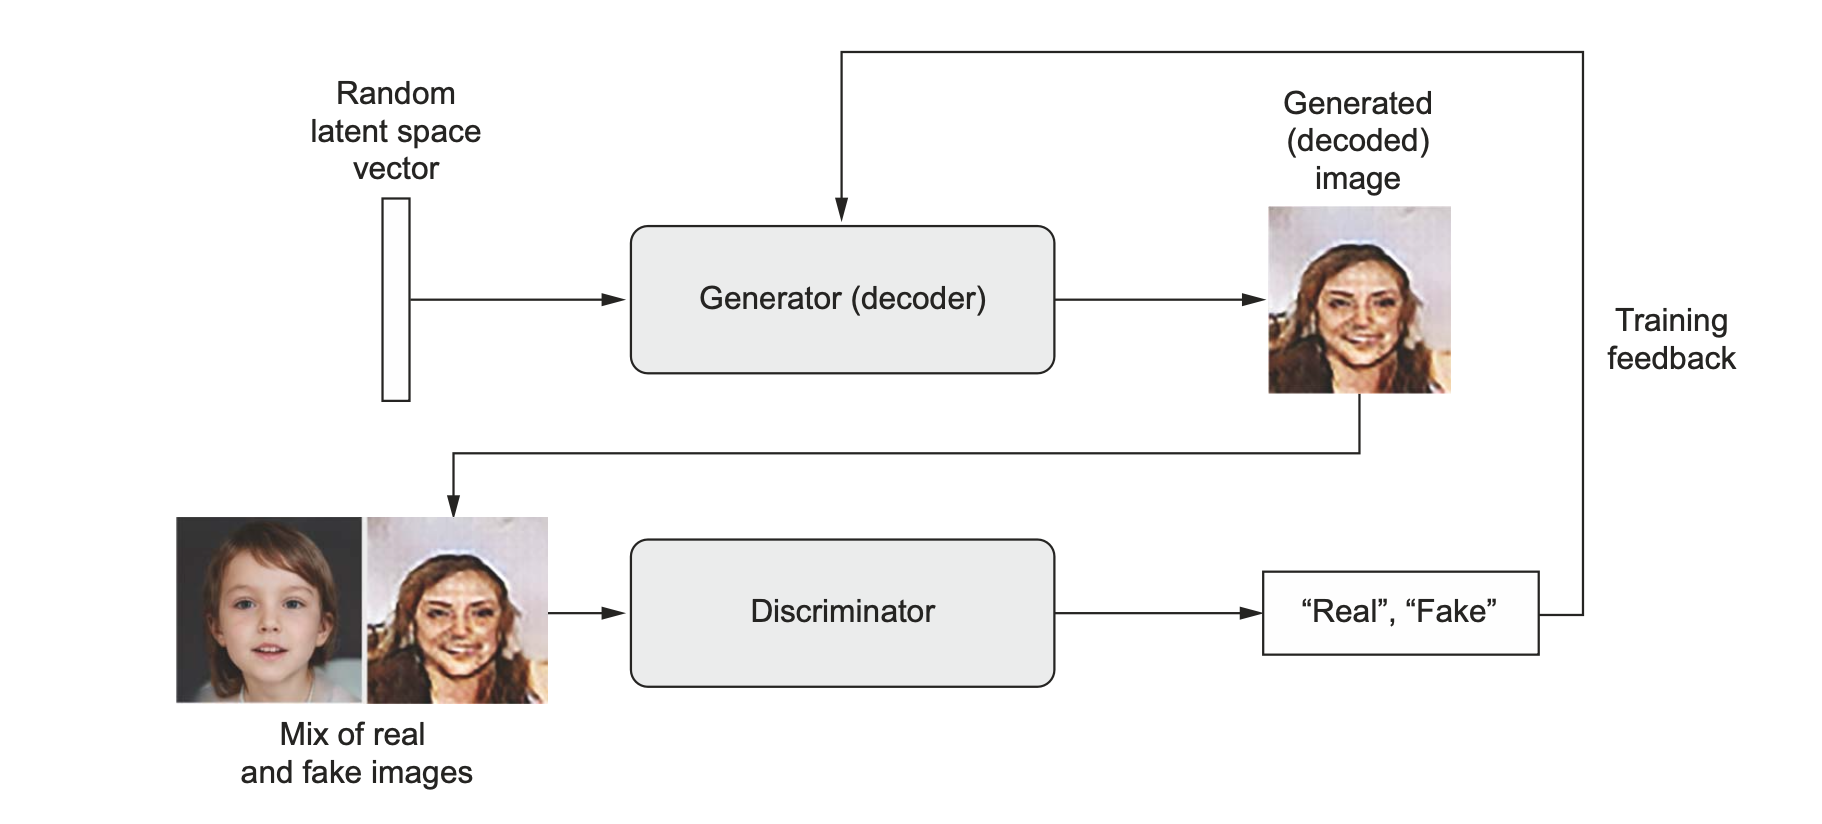

### <ins />**Descriminator / Adversarial / Classifier Network:**
  - A network to classify image using:
    - Conv2D feature layers
    - Sigmoid dense logit
  - Considerations:
    - Use strides instead of pooling
      - Location information is important
      - Avoid sparse gradients
    - Use LeakyRelu instead of Relu
      - Avoid sparse gradients
    - Kernel size should be divisible by stride size
    - Use Dropout
      - To avoid generator network producing noisy images

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

### <ins />**Generator / Decoder / Synthesizer Network:**
  - A network to decode vector into image using:
    - Conv2DTranspose upsampling layers
    - Conv2D logit layer
  - Upsampling network to produce high resolution image
  - Similar to semantic segmentation second part

In [6]:
latent_dim = 128  # Latent space is 128-dimensional vectors
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        # Reshape is opposite of flatten layer
        layers.Reshape((8, 8, 128)),
        # revert the Conv2D layer of encoder
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # LeakyReLU is used to avoid sparse gradients
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # Output shape is 28,28,1
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

### <ins />**Generative Adversarial Network (GAN) / Decoder Descriminator Network (DDN):**
- We are using DCGAN (Deep Convolution GAN)
- Generate images with random noise using generator
- Combine real images and generated images
- Combine real labels (0) and generated labels (1)
- **Add random noise in the labels. So labels are not 0/1 anymore**
- Train the discriminator:
  - For all images, classify labels [real=0, generated=1] [in practice, probability (see above point)]
  - Find dicriminator loss and its gradient
  - Apply backpropagation to update weights (GradientTape)
- Train the generator:
  - **Sample new random noise** and generate images using generator
  - Give these images **fake real labels (0)**
  - Use discriminator to classify these labels (Feedback)
  - Now we have predictions and fake labels
  - Find generator loss and its gradient
  - Apply backpropagation to update weights (GradientTape)
- Training is complete when Nash equilibrium is achieved (both can't improve further)
- A callback runs every epoch to generate images with latest weights to visualize training progress

**Discriminator Loss:**
| | |
| --- | --- |
| BinaryCrossEntropy ||
| log(Dx) | Likelihood it classifies real image as real. Should be close to 1 |
| log(1 - D(Gz)) | Likelihood it classifies fake images as real. Should be close to 0 |

**Generator Loss:**
| | |
| --- | --- |
| BinaryCrossEntropy ||
| log(D(Gz)) | Likelihood that discriminator gets fooled by generated image. Should be close to 1 |

**Optimizer and Metric:**
  - Adam
  - Mean

**Tips for GAN convergance:**
  - Generator never sees real training images. It has indirect information from discriminator classification which affects its loss function
  - Add random noise in labels before training discriminator (probability instead of binary)
  - Use Wasserstein loss instead of BCE for generator
  - Decrease discriminator learning rate
  - Increase discriminator dropout

**What is different from Reinforcement learning?**
- In GAN, both networks are part of training
- In RL, only Agent is a training network

| Reinforcement Learning | Generative Adversarial |
| --- | --- |
| Agent | Generator |
| Action | Sampling |
| Environment | Discriminator |
| Reward | Feedback |